In [1]:
!pip install brainflow

In [2]:
import numpy as np
import brainflow
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, AggOperations
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import time

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds

import os

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.preprocessing import (
    compute_proj_ecg,
    compute_proj_eog,
    create_ecg_epochs,
    create_eog_epochs,
)





[[     0.    45997.52  46077.2  ...  43556.62  43561.78  43535.81]
 [     0.    37487.45  37578.29 ...  37944.23  37951.61  37910.48]
 [     0.   -22369.71 -22259.92 ... -22341.8  -22375.53 -22395.15]
 ...
 [     0.   -24777.78 -24711.8  ... -24640.09 -24663.58 -24637.92]
 [     0.   -10055.49  -9977.57 ...  -9024.16  -9063.45  -9055.83]
 [     0.    -3746.69  -3650.2  ...  -3427.68  -3476.52  -3487.16]]
Data From the File
        0         1         2         3         4         5         6    \
0  0.000000  0.045998  0.046077  0.046158  0.046112  0.046003  0.046050   
1  0.046058  0.046033  0.046068  0.046083  0.046044  0.046025  0.046064   
2  0.045932  0.045942  0.045994  0.045976  0.045938  0.045950  0.045997   
3  0.045956  0.045976  0.046010  0.045988  0.045945  0.045964  0.046013   
4  0.043491  0.043543  0.043578  0.043544  0.043517  0.043564  0.043614   
5  0.043286  0.043339  0.043352  0.043327  0.043318  0.043371  0.043390   
6  0.041734  0.041812  0.041849  0.041843  0.041

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8736\1791403757.py:49: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
59 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 176 original time points ...
1 bad epochs dropped


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8736\1791403757.py:66: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked.plot(spatial_colors=True, gfp=True)


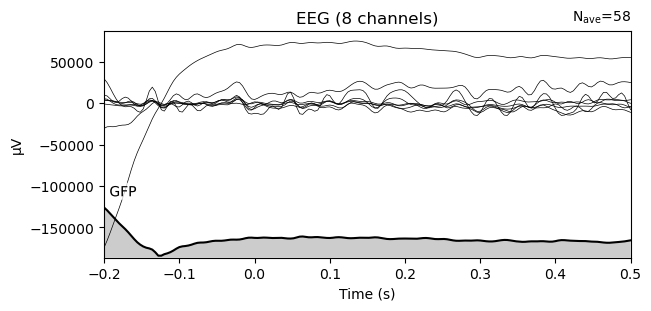

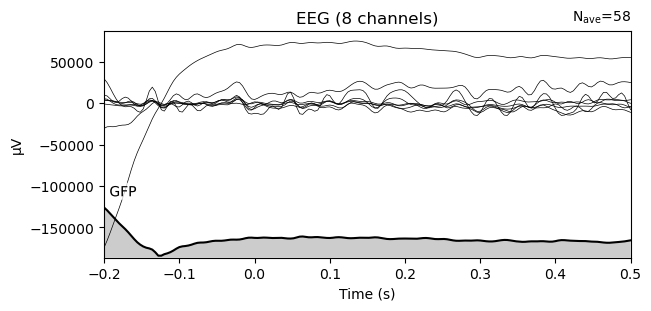

In [10]:
import pandas as pd
import numpy as np
import mne
from brainflow.data_filter import DataFilter

# Especifica el path de tu archivo de OpenBCI
file_path = 'OpenBCI_GUI-v5-meditation.txt'

# Leer el archivo de texto
data = pd.read_csv(file_path, comment='%', header=None)

# Extraer las columnas relevantes (suponiendo que las primeras 8 columnas después de la columna de índice son los datos de EEG) y todas las filas
eeg_data = data.iloc[1:30000, 1:9]
eeg_trans = pd.DataFrame(np.transpose(eeg_data))
eeg = eeg_trans.to_numpy()

# Verifica la estructura de los datos
print(eeg)

eeg_channels = [1, 2, 3, 4, 5, 6, 7, 8]
eeg_data = eeg / 1000000  # Convertir de microvoltios a voltios

eeg_trans = pd.DataFrame(np.transpose(eeg_data))
eeg_trans = np.ascontiguousarray(eeg_trans)
DataFilter.write_file(eeg_trans, 'test.csv', 'w') 
restored_data = DataFilter.read_file('test.csv')
restored_df = pd.DataFrame(np.transpose(restored_data))
print('Data From the File')
print(restored_df.head(10))

# Crear un objeto Raw de MNE
ch_types = ['eeg'] * len(eeg_channels)
ch_names = [
    "FC3",
    "FCz",
    "FC4",
    "C3",
    "Cz",
    "C4",
    "CP3",
    "CPz"
]
sfreq = 250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# Aplicación de ICA
ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [0]  # Índices para excluir basados en inspección manual o métodos automáticos
reconst_raw = raw.copy()
ica.apply(reconst_raw)

# Filtrado
reconst_raw.filter(l_freq=1., h_freq=40.)

# Normalización
reconst_raw.apply_function(lambda x: (x - np.mean(x)) / np.std(x), picks=['eeg'])

# Crear eventos sintéticos para demostración
events = mne.make_fixed_length_events(reconst_raw, start=0, stop=None, duration=2.0)
epochs = mne.Epochs(reconst_raw, events, event_id=1, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)
evoked = epochs.average()

# Graficar los datos evocados  y GFP
evoked.plot(spatial_colors=True, gfp=True)





